# Phase 1 — Exposure Landscape
This notebook implements the Phase‑1 exposure analysis (occupation + industry), using `srvy_wght_tru2` as the primary weight. All outputs are exported under `Results Datasets/analysis/phase1/`.

## Setup + Phase 1 summary

In [69]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paths
def find_root():
    if "__file__" in globals():
        return Path(__file__).resolve().parents[2]
    cwd = Path.cwd().resolve()
    for p in [cwd] + list(cwd.parents):
        if (p / "Results Datasets" / "final_analysis_dataset.parquet").exists():
            return p
    return cwd
ROOT = find_root()
DATA_PATH = ROOT / "Results Datasets" / "final_analysis_dataset.parquet"
OUT_ROOT = ROOT / "Results Datasets" / "analysis" / "phase1"
OUT_TABLES = OUT_ROOT / "tables"
OUT_VIS = OUT_ROOT / "visuals"
for d in [OUT_ROOT, OUT_TABLES, OUT_VIS]:
    d.mkdir(parents=True, exist_ok=True)

# --- Load data
if not DATA_PATH.exists():
    raise FileNotFoundError(DATA_PATH)

cols = None  # load all
_df = pd.read_parquet(DATA_PATH)
# Year filter
_df = _df[(_df["adve_time_year"] >= 2010) & (_df["adve_time_year"] <= 2024)].copy()

# Core columns
occ_exp_col = "occupation_exposure"
ind_exp_col = "industry_exposure_weighted"
occ_raw_col = "occu_isco_2008"  # raw ISCO
noga_col = "comp_indu_noga"

# Ensure numeric exposure
for col in [occ_exp_col, ind_exp_col]:
    _df[col] = pd.to_numeric(_df[col], errors="coerce")

# --- Labels (cross‑walks)
CW_DIR = ROOT / "External datasets" / "Cross-walks"

# NOGA labels
noga_map = {}
path_noga = CW_DIR / "comp_indu_noga_to_noga2digit_expanded.csv"
if path_noga.exists():
    noga = pd.read_csv(path_noga)
    noga["comp_indu_noga"] = pd.to_numeric(noga["comp_indu_noga"], errors="coerce")
    noga_map = (
        noga.dropna(subset=["comp_indu_noga"])
        .drop_duplicates(subset=["comp_indu_noga"])
        .set_index("comp_indu_noga")["label_de"].to_dict()
    )

# ISCO labels
isco1_map = {}
isco2_map = {}
path_isco1 = CW_DIR / "isco_major_code_to_label.csv"
path_isco2 = CW_DIR / "isco_08_submajor_2digit_code_to_label.csv"
if path_isco1.exists():
    t = pd.read_csv(path_isco1)
    t["isco_major"] = pd.to_numeric(t["isco_major"], errors="coerce")
    isco1_map = t.set_index("isco_major")["label_en"].to_dict()
if path_isco2.exists():
    t = pd.read_csv(path_isco2)
    t["isco_08_submajor_2d"] = pd.to_numeric(t["isco_08_submajor_2d"], errors="coerce")
    isco2_map = t.set_index("isco_08_submajor_2d")["label_en"].to_dict()

# Build raw ISCO string
isco_raw_str = _df[occ_raw_col].astype("string").str.split(".").str[0]
isco_raw_str = isco_raw_str.str.replace(r"[^0-9]", "", regex=True)
# zero-fill to 4 digits if numeric and length < 4
isco_raw_str = isco_raw_str.apply(lambda x: x.zfill(4) if x is not pd.NA and str(x).isdigit() and len(str(x)) < 4 else x)

major_placeholders = {"1000","2000","3000","4000","5000","6000","7000","8000","9000"}
isco_is_major_placeholder = isco_raw_str.isin(major_placeholders)

# Labels (do not add permanent new code columns to dataset; just build series)
isco1_label = isco_raw_str.str[:1].apply(lambda x: isco1_map.get(int(x)) if str(x).isdigit() else pd.NA)
isco2_label = isco_raw_str.apply(
    lambda x: "Unknown sub-major (major group only)" if x in major_placeholders else (
        isco2_map.get(int(str(x)[:2])) if str(x)[:2].isdigit() else pd.NA
    )
)

_df["comp_indu_noga_label"] = pd.to_numeric(_df[noga_col], errors="coerce").map(noga_map).astype("string")
_df["occu_isco1_label"] = isco1_label.astype("string")
_df["occu_isco2_label"] = isco2_label.astype("string")
_df["isco_is_major_placeholder"] = isco_is_major_placeholder

# Diagnostic table for placeholders
placeholder_counts = (
    pd.DataFrame({"isco_raw": isco_raw_str, "is_placeholder": isco_is_major_placeholder})
    .loc[isco_is_major_placeholder, "isco_raw"]
    .value_counts()
    .rename_axis("isco_raw")
    .reset_index(name="count")
)
placeholder_diag = pd.DataFrame({
    "total_rows": [len(_df)],
    "placeholder_rows": [isco_is_major_placeholder.sum()],
    "placeholder_share": [isco_is_major_placeholder.mean()],
})
placeholder_diag.to_csv(OUT_TABLES / "table_isco_placeholder_diagnostic.csv", index=False)

# Region labels (Unknown kept)
special_codes = {"-3","-7","-8","-9"}

canton_map = {
    1:"ZH",2:"BE",3:"LU",4:"UR",5:"SZ",6:"OW",7:"NW",8:"GL",9:"ZG",
    10:"FR",11:"SO",12:"BS",13:"BL",14:"SH",15:"AR",16:"AI",17:"SG",
    18:"GR",19:"AG",20:"TG",21:"TI",22:"VD",23:"VS",24:"NE",25:"GE",26:"JU"
}

def label_region(series, is_canton=False):
    raw = series.astype("string")
    lab = raw.where(~raw.isin(special_codes), other="Unknown")
    lab = lab.fillna("Unknown")
    if is_canton:
        def map_canton(val):
            if val == "Unknown" or pd.isna(val):
                return "Unknown"
            return canton_map.get(int(val), val) if str(val).isdigit() else val
        lab = lab.apply(map_canton)
    return lab.astype("string")

_df["loca_regi_kant_label"] = label_region(_df["loca_regi_kant"], is_canton=True)
_df["loca_regi_nuts_label"] = label_region(_df["loca_regi_nuts"], is_canton=False)

# Thresholds (global, unweighted)
occ_p80, occ_p90 = _df[occ_exp_col].quantile([0.8,0.9]).values
ind_p80, ind_p90 = _df[ind_exp_col].quantile([0.8,0.9]).values

# Coverage (tru2-weighted)
tru2_total = _df["srvy_wght_tru2"].sum()
occ_cov_tru2 = _df.loc[_df[occ_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total
ind_cov_tru2 = _df.loc[_df[ind_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total

# Unknown region share (tru2)
unknown_kant_share = _df.loc[_df["loca_regi_kant_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total
unknown_nuts_share = _df.loc[_df["loca_regi_nuts_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total

summary = {
    "thresholds": {
        "occ_p80": float(occ_p80), "occ_p90": float(occ_p90),
        "ind_p80": float(ind_p80), "ind_p90": float(ind_p90),
    },
    "coverage_tru2": {"occ": float(occ_cov_tru2), "ind": float(ind_cov_tru2)},
    "unknown_region_share_tru2": {"kanton": float(unknown_kant_share), "nuts": float(unknown_nuts_share)},
    "scatter_label_strategy": "labels = top 10 by demand + top 10 by mean exposure + top 10 by exposed demand (+ optional lowest exposure); deduplicated",
}

(OUT_ROOT / "phase1_summary.json").write_text(json.dumps(summary, indent=2))
summary


{'thresholds': {'occ_p80': 1.2383682999999999,
  'occ_p90': 1.284863,
  'ind_p80': 0.9475425749999999,
  'ind_p90': 1.186285442857143},
 'coverage_tru2': {'occ': 0.9183896392364413, 'ind': 0.9489883855451481},
 'unknown_region_share_tru2': {'kanton': 0.060835489601052714,
  'nuts': 0.060835489601052714},
 'scatter_label_strategy': 'labels = top 10 by demand + top 10 by mean exposure + top 10 by exposed demand (+ optional lowest exposure); deduplicated'}

## 3) Exposure distributions (CDFs)

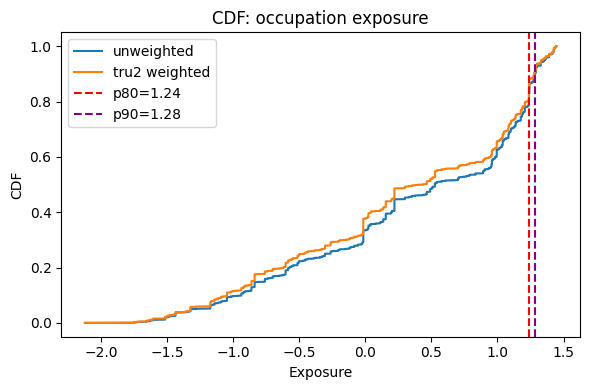

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_cdf_occ.png


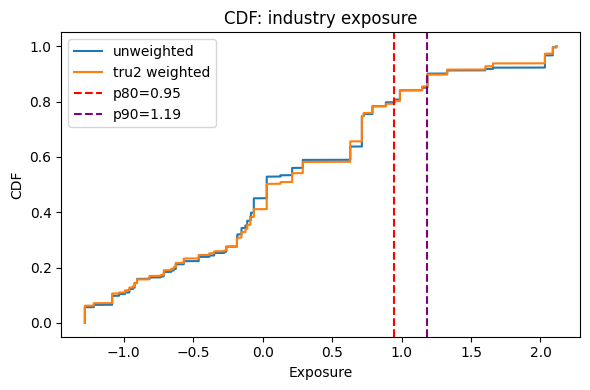

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_cdf_ind.png


In [70]:
def plot_cdf(series, weights=None, label="weighted", ax=None):
    s = series.dropna().to_numpy()
    if weights is None:
        w = np.ones_like(s)
    else:
        w = weights.loc[series.dropna().index].to_numpy()
    order = np.argsort(s)
    s_sorted = s[order]
    w_sorted = w[order]
    cum = np.cumsum(w_sorted)
    cum = cum / cum[-1]
    ax.plot(s_sorted, cum, label=label)

# Occupation CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(_df[occ_exp_col], None, label="unweighted", ax=ax)
plot_cdf(_df[occ_exp_col], _df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(occ_p80, color='red', linestyle='--', label=f'p80={occ_p80:.2f}')
ax.axvline(occ_p90, color='purple', linestyle='--', label=f'p90={occ_p90:.2f}')
ax.set_title("CDF: occupation exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_cdf_occ.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Industry CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(_df[ind_exp_col], None, label="unweighted", ax=ax)
plot_cdf(_df[ind_exp_col], _df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(ind_p80, color='red', linestyle='--', label=f'p80={ind_p80:.2f}')
ax.axvline(ind_p90, color='purple', linestyle='--', label=f'p90={ind_p90:.2f}')
ax.set_title("CDF: industry exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_cdf_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


# Occupation distribution (non-cumulative)
fig, ax = plt.subplots(figsize=(6,4))
occ_s = _df[occ_exp_col].dropna()
occ_w = _df.loc[occ_s.index, "srvy_wght_tru2"]
bins = 40
ax.hist(occ_s, bins=bins, density=True, alpha=0.4, label="unweighted")
ax.hist(occ_s, bins=bins, density=True, weights=occ_w, alpha=0.4, label="tru2 weighted")
ax.axvline(occ_p80, color='red', linestyle='--', label=f'p80={occ_p80:.2f}')
ax.axvline(occ_p90, color='purple', linestyle='--', label=f'p90={occ_p90:.2f}')
ax.set_title("Distribution: occupation exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_pdf_occ.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Industry distribution (non-cumulative)
fig, ax = plt.subplots(figsize=(6,4))
ind_s = _df[ind_exp_col].dropna()
ind_w = _df.loc[ind_s.index, "srvy_wght_tru2"]
ax.hist(ind_s, bins=bins, density=True, alpha=0.4, label="unweighted")
ax.hist(ind_s, bins=bins, density=True, weights=ind_w, alpha=0.4, label="tru2 weighted")
ax.axvline(ind_p80, color='red', linestyle='--', label=f'p80={ind_p80:.2f}')
ax.axvline(ind_p90, color='purple', linestyle='--', label=f'p90={ind_p90:.2f}')
ax.set_title("Distribution: industry exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_pdf_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 4) Concentration: Top‑X curve + summary

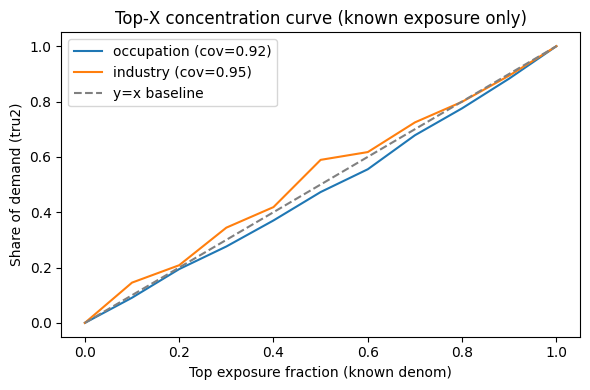

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_topx_known_denom.png


,top_fraction,occ_share,ind_share
0,0.0,0.000000,0.000000
1,0.1,0.090915,0.145514
2,0.2,0.194322,0.208364
3,0.3,0.276060,0.344134
4,0.4,0.370185,0.418411
5,0.5,0.472856,0.589156
6,0.6,0.555198,0.617293
7,0.7,0.678099,0.724606
8,0.8,0.775447,0.799009
9,0.9,0.883051,0.893890


In [71]:
def demand_share_at_threshold(col, thresh, weight_col):
    mask = _df[col] >= thresh
    return _df.loc[mask, weight_col].sum() / _df[weight_col].sum()

rows = []
for col, label in [(occ_exp_col, "occupation"), (ind_exp_col, "industry")]:
    p80, p90 = _df[col].quantile([0.8,0.9]).values
    row = {"measure": label}
    row["p80"] = p80
    row["p90"] = p90
    row["coverage_tru2"] = _df.loc[_df[col].notna(), "srvy_wght_tru2"].sum() / _df["srvy_wght_tru2"].sum()
    # tru2
    row["share_top10_tru2"] = demand_share_at_threshold(col, p90, "srvy_wght_tru2")
    row["share_top20_tru2"] = demand_share_at_threshold(col, p80, "srvy_wght_tru2")
    row["share_top50_tru2"] = demand_share_at_threshold(col, _df[col].quantile(0.5), "srvy_wght_tru2")
    row["share_bottom10_tru2"] = _df.loc[_df[col] <= _df[col].quantile(0.1), "srvy_wght_tru2"].sum() / _df["srvy_wght_tru2"].sum()
    # tru1 check
    row["share_top10_tru1"] = demand_share_at_threshold(col, p90, "srvy_wght_tru1")
    row["share_top20_tru1"] = demand_share_at_threshold(col, p80, "srvy_wght_tru1")
    row["share_top50_tru1"] = demand_share_at_threshold(col, _df[col].quantile(0.5), "srvy_wght_tru1")
    row["share_bottom10_tru1"] = _df.loc[_df[col] <= _df[col].quantile(0.1), "srvy_wght_tru1"].sum() / _df["srvy_wght_tru1"].sum()
    rows.append(row)

concentration_tbl = pd.DataFrame(rows)
concentration_tbl.to_csv(OUT_TABLES / "table_concentration_summary.csv", index=False)
concentration_tbl

# Known-denom Top-X curve
occ_nonmiss = _df[_df[occ_exp_col].notna()].copy()
ind_nonmiss = _df[_df[ind_exp_col].notna()].copy()
occ_total = occ_nonmiss['srvy_wght_tru2'].sum()
ind_total = ind_nonmiss['srvy_wght_tru2'].sum()
xs = np.linspace(0, 1, 11)

def topx_share_nonmiss(sub_df, col, frac):
    if frac <= 0:
        return 0.0
    s = pd.to_numeric(sub_df[col], errors='coerce').to_numpy(dtype=float)
    w = sub_df['srvy_wght_tru2'].to_numpy(dtype=float)
    valid = ~np.isnan(s)
    s = s[valid]
    w = w[valid]
    if len(s) == 0:
        return np.nan
    cutoff = np.nanquantile(s, 1 - frac)
    mask = s >= cutoff
    return w[mask].sum() / w.sum()

rows = []
for x in xs:
    rows.append({
        'top_fraction': x,
        'occ_share': topx_share_nonmiss(occ_nonmiss, occ_exp_col, x),
        'ind_share': topx_share_nonmiss(ind_nonmiss, ind_exp_col, x),
    })
conc_curve = pd.DataFrame(rows)

cov_occ = occ_total / _df['srvy_wght_tru2'].sum()
cov_ind = ind_total / _df['srvy_wght_tru2'].sum()

plt.figure(figsize=(6,4))
plt.plot(conc_curve['top_fraction'], conc_curve['occ_share'], label=f'occupation (cov={cov_occ:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['ind_share'], label=f'industry (cov={cov_ind:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['top_fraction'], linestyle='--', color='gray', label='y=x baseline')
plt.xlabel('Top exposure fraction (known denom)')
plt.ylabel('Share of demand (tru2)')
plt.title('Top‑X concentration curve (known exposure only)')
plt.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_topx_known_denom.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)
conc_curve


## 5) Impact zones — Occupations (ISCO 2‑digit)

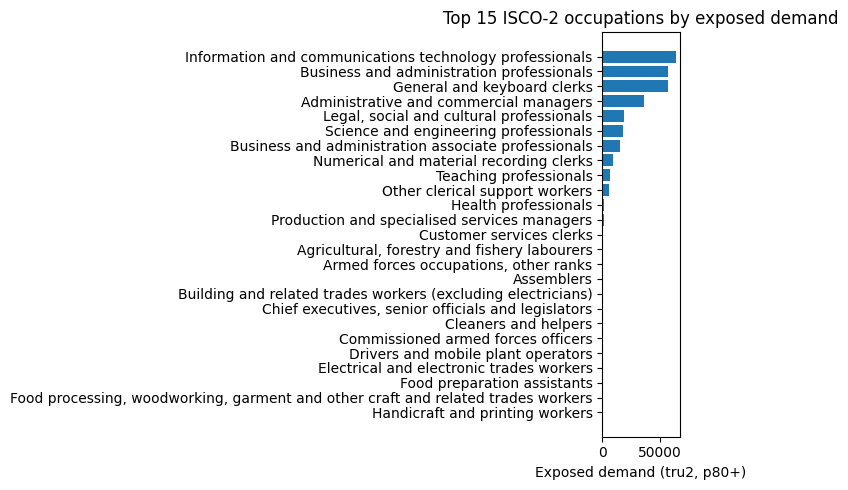

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_occ2_top15_exposed_p80.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


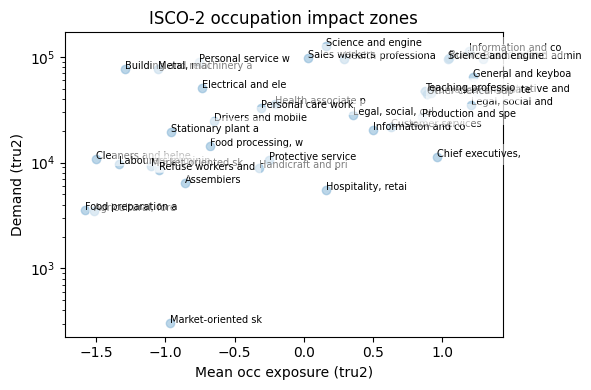

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_occ2_scatter.png


In [72]:
# Build 2-digit ISCO grouping (in-memory only)
occ2_code = isco_raw_str.str[:2]
occ2_label = _df["occu_isco2_label"].fillna("Unknown")

# Metrics per 2-digit group
p80_occ, p90_occ = occ_p80, occ_p90
occ2_group = _df.groupby(occ2_label)

def wmean(group, col):
    x = group[col]
    w = group["srvy_wght_tru2"]
    mask = x.notna()
    if mask.sum() == 0:
        return np.nan
    return np.average(x[mask], weights=w[mask])

occ2_metrics = occ2_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum"),
    n_ads=("srvy_wght_tru2","size")
).reset_index().rename(columns={"occu_isco2_label":"occ2_label"})

occ2_metrics["mean_occ_exp_tru2"] = occ2_group.apply(lambda g: wmean(g, occ_exp_col)).values
occ2_metrics["exposed_demand_p80"] = _df.loc[_df[occ_exp_col] >= p80_occ].groupby(occ2_label)["srvy_wght_tru2"].sum().reindex(occ2_metrics["occ2_label"]).fillna(0).values
occ2_metrics["exposed_demand_p90"] = _df.loc[_df[occ_exp_col] >= p90_occ].groupby(occ2_label)["srvy_wght_tru2"].sum().reindex(occ2_metrics["occ2_label"]).fillna(0).values
occ2_metrics["high_share_p80"] = occ2_metrics["exposed_demand_p80"] / occ2_metrics["demand_total_tru2"]

# Tables
occ2_top25_exposed = occ2_metrics.nlargest(25, "exposed_demand_p80")
occ2_top25_exposed.to_csv(OUT_TABLES / "table_occ2_top25_exposed_p80.csv", index=False)

# bottom 15 by mean exposure with minimal demand threshold (visible, permissive)
min_demand_threshold = 0  # low threshold by design
occ2_bottom15 = occ2_metrics[occ2_metrics["demand_total_tru2"] > min_demand_threshold].nsmallest(15, "mean_occ_exp_tru2")
occ2_bottom15.to_csv(OUT_TABLES / "table_occ2_bottom15_meanexp.csv", index=False)

# 4-digit detail table (top 25 by exposed demand)
occ4_code = isco_raw_str
occ4_group = _df.groupby(occ4_code)
occ4_metrics = occ4_group["srvy_wght_tru2"].sum().rename("demand_total_tru2").to_frame()
occ4_metrics["exposed_demand_p80"] = _df.loc[_df[occ_exp_col] >= p80_occ].groupby(occ4_code)["srvy_wght_tru2"].sum()
occ4_metrics = occ4_metrics.fillna(0).reset_index().rename(columns={"index":"isco4_code"})
occ4_top25 = occ4_metrics.nlargest(25, "exposed_demand_p80")
occ4_top25.to_csv(OUT_TABLES / "table_occ4_top25_exposed_p80.csv", index=False)

occ2_top25_exposed.head(), occ2_bottom15.head(), occ4_top25.head()

# Plot: top 15 exposed demand
bar_data = occ2_top25_exposed.nlargest(150, "exposed_demand_p80")
plt.figure(figsize=(7,5))
plt.barh(bar_data["occ2_label"].astype(str), bar_data["exposed_demand_p80"])
plt.gca().invert_yaxis()
plt.xlabel("Exposed demand (tru2, p80+)")
plt.title("Top 15 ISCO‑2 occupations by exposed demand")
plt.tight_layout()
fig_path = OUT_VIS / "fig_occ2_top15_exposed_p80.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Scatter with controlled labels
plt.figure(figsize=(6,4))
plt.scatter(occ2_metrics["mean_occ_exp_tru2"], occ2_metrics["demand_total_tru2"], alpha=0.6)
# label strategy
label_set = set()
label_set.update(occ2_metrics.nlargest(100, "demand_total_tru2")["occ2_label"].tolist())
label_set.update(occ2_metrics.nlargest(100, "mean_occ_exp_tru2")["occ2_label"].tolist())
label_set.update(occ2_metrics.nlargest(100, "exposed_demand_p80")["occ2_label"].tolist())
label_set.update(occ2_bottom15.nsmallest(5, "mean_occ_exp_tru2")["occ2_label"].tolist())
for _, row in occ2_metrics[occ2_metrics["occ2_label"].isin(label_set)].iterrows():
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], str(row["occ2_label"])[:18], fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("ISCO‑2 occupation impact zones")
plt.tight_layout()
fig_path = OUT_VIS / "fig_occ2_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 5.2) Impact zones — Industries (NOGA)

/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_75159/2900007939.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


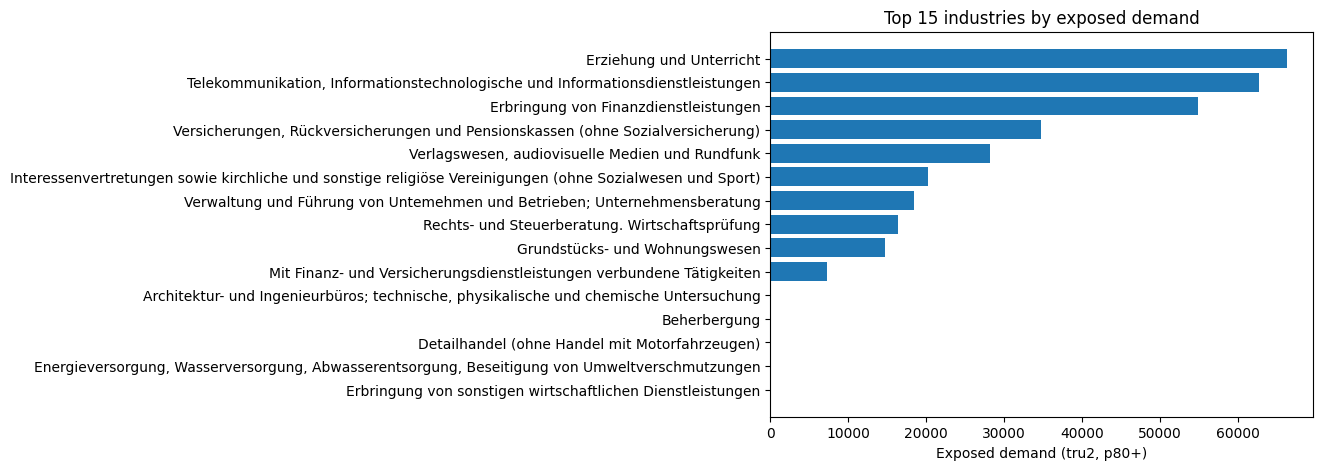

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_top15_exposed_p80.png


posx and posy should be finite values


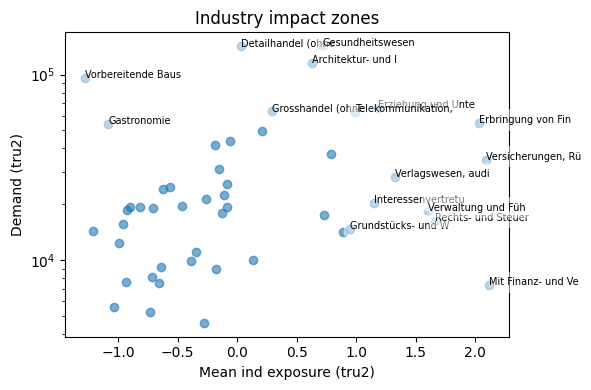

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_scatter.png


In [73]:
# Industry metrics
ind_group = _df.groupby(_df["comp_indu_noga_label"].fillna("Unknown"))
ind_metrics = ind_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum"),
    n_ads=("srvy_wght_tru2","size")
).reset_index().rename(columns={"comp_indu_noga_label":"indu_label"})

ind_metrics["mean_ind_exp_tru2"] = ind_group.apply(lambda g: wmean(g, ind_exp_col)).values
ind_metrics["exposed_demand_p80"] = _df.loc[_df[ind_exp_col] >= ind_p80].groupby(_df["comp_indu_noga_label"].fillna("Unknown"))["srvy_wght_tru2"].sum().reindex(ind_metrics["indu_label"]).fillna(0).values
ind_metrics["high_share_p80"] = ind_metrics["exposed_demand_p80"] / ind_metrics["demand_total_tru2"]

# Tables
ind_top25_exposed = ind_metrics.nlargest(25, "exposed_demand_p80")
ind_top25_exposed.to_csv(OUT_TABLES / "table_ind_top25_exposed_p80.csv", index=False)

ind_bottom15 = ind_metrics[ind_metrics["demand_total_tru2"] > 0].nsmallest(15, "mean_ind_exp_tru2")
ind_bottom15.to_csv(OUT_TABLES / "table_ind_bottom15_meanexp.csv", index=False)

# Plot: top 15 exposed demand
plt.figure(figsize=(7,5))
bar_data = ind_top25_exposed.nlargest(15, "exposed_demand_p80")
plt.barh(bar_data["indu_label"].astype(str), bar_data["exposed_demand_p80"])
plt.gca().invert_yaxis()
plt.xlabel("Exposed demand (tru2, p80+)")
plt.title("Top 15 industries by exposed demand")
plt.tight_layout()
fig_path = OUT_VIS / "fig_ind_top15_exposed_p80.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Scatter
plt.figure(figsize=(6,4))
plt.scatter(ind_metrics["mean_ind_exp_tru2"], ind_metrics["demand_total_tru2"], alpha=0.6)
label_set = set()
label_set.update(ind_metrics.nlargest(10, "demand_total_tru2")["indu_label"].tolist())
label_set.update(ind_metrics.nlargest(10, "mean_ind_exp_tru2")["indu_label"].tolist())
label_set.update(ind_metrics.nlargest(10, "exposed_demand_p80")["indu_label"].tolist())
for _, row in ind_metrics[ind_metrics["indu_label"].isin(label_set)].iterrows():
    plt.text(row["mean_ind_exp_tru2"], row["demand_total_tru2"], str(row["indu_label"])[:18], fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean ind exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Industry impact zones")
plt.tight_layout()
fig_path = OUT_VIS / "fig_ind_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 6) Regions (Unknown kept)

### 6.1) Regions — occupation exposure


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/319849732.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics["mean_occ_exp_tru2"] = reg_group.apply(wmean_region)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/319849732.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].s

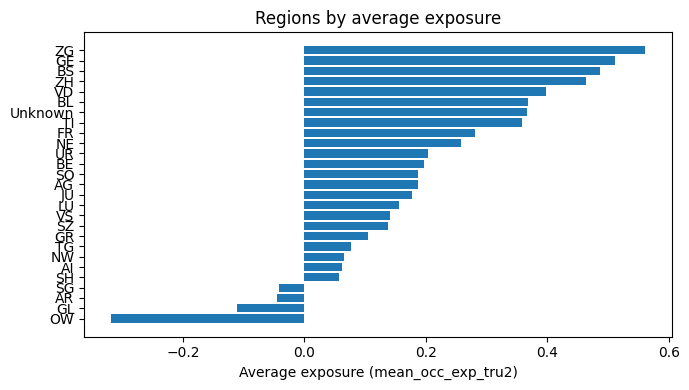

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_avg_exposure.png


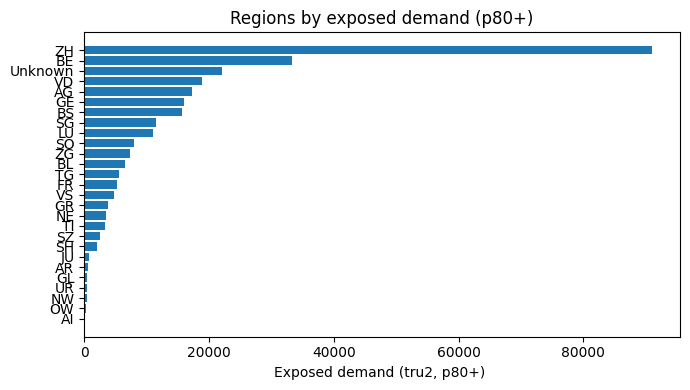

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p80.png


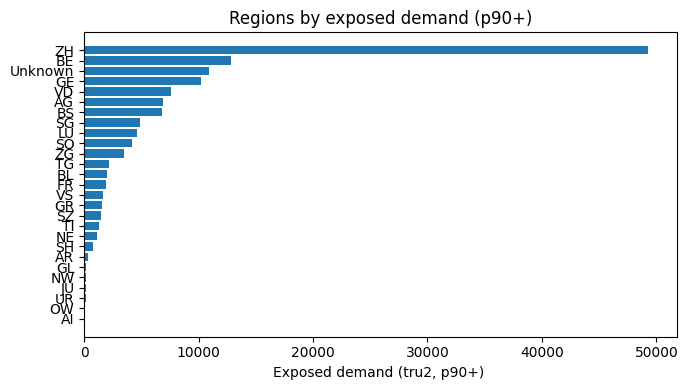

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p90.png


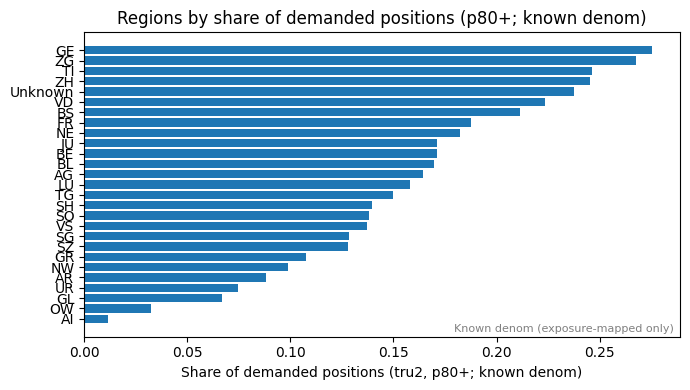

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p80.png


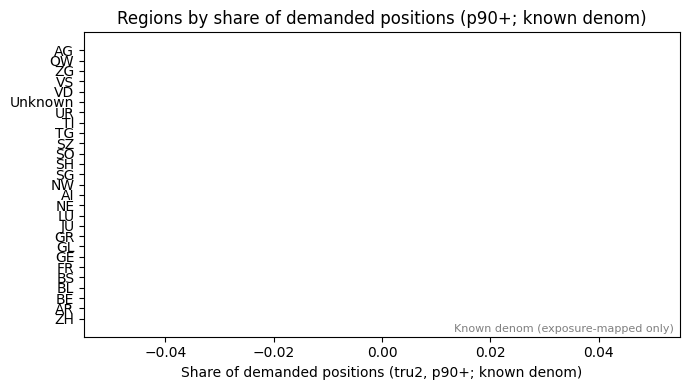

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p90.png


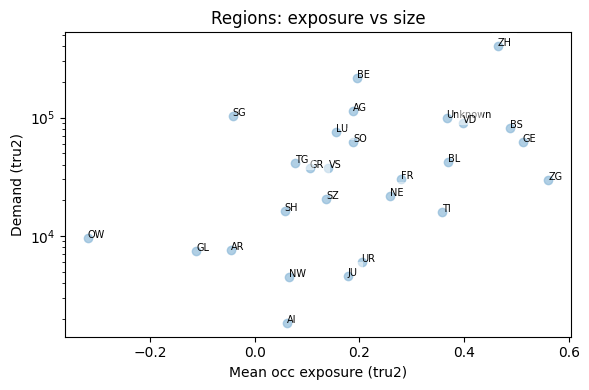

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_scatter.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/319849732.py:159: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"])


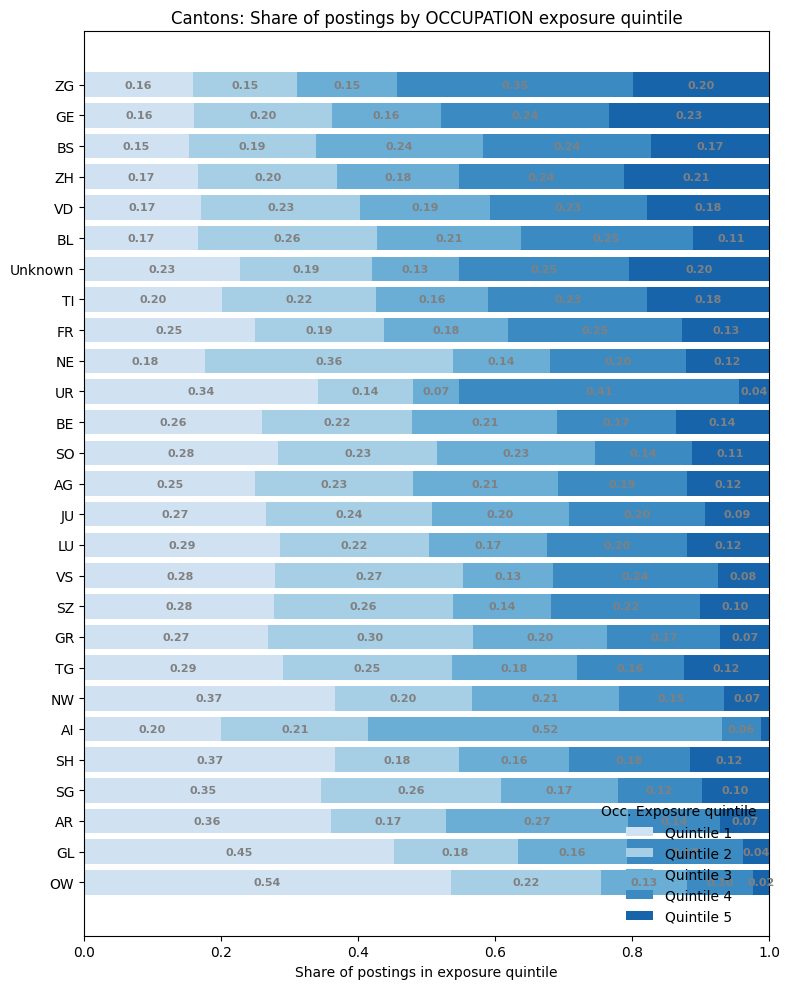

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_quintiles_occ_exp.png


In [178]:
region_col = "loca_regi_kant_label"

# Region summary
reg_group = _df.groupby(region_col)

def wmean_region(g):
    x = g.loc[g[occ_exp_col].notna(), occ_exp_col]
    w = g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]
    return np.average(x, weights=w) if len(x) else np.nan

reg_metrics = reg_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum")
)
reg_metrics["mean_occ_exp_tru2"] = reg_group.apply(wmean_region)

# exposed demand p80/p90
reg_metrics["exposed_demand_p80"] = _df.loc[_df[occ_exp_col] >= occ_p80].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics["exposed_demand_p90"] = _df.loc[_df[occ_exp_col] >= occ_p90].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics = reg_metrics.fillna(0)

# shares
known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics["high_share_total_p80"] = reg_metrics["exposed_demand_p80"] / reg_metrics["demand_total_tru2"]
reg_metrics["high_share_known_p80"] = reg_metrics["exposed_demand_p80"] / known_denom
reg_metrics["coverage_share"] = known_denom / reg_metrics["demand_total_tru2"]

reg_metrics["high_share_total_p90"] = reg_metrics["exposed_demand_p90"] / reg_metrics["demand_total_tru2"]
reg_metrics["high_share_known_p90"] = reg_metrics["exposed_demand_p90"] / known_denom
reg_metrics = reg_metrics.reset_index()
reg_metrics.to_csv(OUT_TABLES / "table_region_summary.csv", index=False)

# Bar charts
# Plot bar chart for average exposure (mean_occ_exp_tru2) by region
top_reg_exp = reg_metrics.nlargest(30, "mean_occ_exp_tru2")
plt.figure(figsize=(7,4))
plt.barh(top_reg_exp[region_col].astype(str), top_reg_exp["mean_occ_exp_tru2"])
plt.gca().invert_yaxis()
plt.xlabel("Average exposure (mean_occ_exp_tru2)")
plt.title("Regions by average exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_top30_avg_exposure.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


for thresh_label in ["p80","p90"]:
    col = f"exposed_demand_{thresh_label}"
    top_reg = reg_metrics.nlargest(30, col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg[region_col].astype(str), top_reg[col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Exposed demand (tru2, {thresh_label}+) ")
    plt.title(f"Regions by exposed demand ({thresh_label}+)")
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top15_exposed_{thresh_label}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Plots for share of demanded positions (high_share_total_p80 and high_share_total_p90) by region

# high_share_total_p80 already exists,
# For high_share_total_p90, compute it first

for thresh_label in ["p80", "p90"]:
    share_col = f"high_share_known_{thresh_label}"
    plot_data = reg_metrics.copy()
    plot_data[region_col] = plot_data[region_col].fillna("Unknown")
    plot_data[share_col] = pd.to_numeric(plot_data[share_col], errors="coerce").fillna(0)
    top_reg_share = plot_data.nlargest(30, share_col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg_share[region_col].astype(str), top_reg_share[share_col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Share of demanded positions (tru2, {thresh_label}+; known denom)")
    plt.title(f"Regions by share of demanded positions ({thresh_label}+; known denom)")
    plt.text(0.99, 0.01, 'Known denom (exposure-mapped only)', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=8, color='gray')
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top30_share_{thresh_label}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)



# Scatter
plt.figure(figsize=(6,4))
plt.scatter(reg_metrics["mean_occ_exp_tru2"], reg_metrics["demand_total_tru2"], alpha=0.7)
label_set = set()
label_set.update(reg_metrics.nlargest(30, "demand_total_tru2")[region_col].tolist())
label_set.update(reg_metrics.nlargest(30, "mean_occ_exp_tru2")[region_col].tolist())
if "Unknown" in reg_metrics[region_col].values:
    label_set.add("Unknown")
for _, row in reg_metrics[reg_metrics[region_col].isin(label_set)].iterrows():
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], str(row[region_col]), fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Regions: exposure vs size")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Decomposition: top 5 regions by exposed demand (p80)
reg_metrics_sorted = reg_metrics.sort_values("exposed_demand_p80", ascending=False)
top_regions = reg_metrics_sorted.head(5)[region_col].tolist()
rows_occ = []
rows_ind = []
for reg in top_regions:
    sub = _df[(_df[region_col] == reg) & (_df[occ_exp_col] >= occ_p80)]
    # top occ2
    sub_occ = sub.groupby(occ2_label)["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_occ.items(), start=1):
        rows_occ.append({"region": reg, "rank": rank, "occ2_label": code, "exposed_demand_tru2": val})
    # top industries
    sub_ind = sub.groupby(_df["comp_indu_noga_label"].fillna("Unknown"))["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_ind.items(), start=1):
        rows_ind.append({"region": reg, "rank": rank, "indu_label": code, "exposed_demand_tru2": val})

pd.DataFrame(rows_occ).to_csv(OUT_TABLES / "table_region_top_occ2_contrib.csv", index=False)
pd.DataFrame(rows_ind).to_csv(OUT_TABLES / "table_region_top_ind_contrib.csv", index=False)


# === Plot: horizontal stacked bars for exposure segments per canton (OCCUPATION exposure, includes P90+) ===
# Build exposure segments using global p20/p40/p60/p80/p90 thresholds
occ_p20, occ_p40, occ_p60, occ_p80_seg, occ_p90_seg = np.nanpercentile(_df[occ_exp_col], [20,40,60,80,90])

def _occ_segment(x):
    if pd.isna(x):
        return pd.NA
    if x <= occ_p20:
        return "Q1 (0-20)"
    if x <= occ_p40:
        return "Q2 (20-40)"
    if x <= occ_p60:
        return "Q3 (40-60)"
    if x <= occ_p80_seg:
        return "Q4 (60-80)"
    if x < occ_p90_seg:
        return "Q5 (80-90)"
    return "P90+ (90-100)"

_df["occ_exposure_segment"] = _df[occ_exp_col].apply(_occ_segment)
segments = ["Q1 (0-20)", "Q2 (20-40)", "Q3 (40-60)", "Q4 (60-80)", "Q5 (80-90)", "P90+ (90-100)"]

postings_per_kanton_segment = (
    _df[_df[region_col].notna() & _df["occ_exposure_segment"].notna()]
      .groupby([region_col, "occ_exposure_segment"], observed=True)["srvy_wght_tru2"].sum()
      .unstack(fill_value=0)
)
for seg in segments:
    if seg not in postings_per_kanton_segment.columns:
        postings_per_kanton_segment[seg] = 0

postings_per_kanton_segment_share = postings_per_kanton_segment.div(
    postings_per_kanton_segment.sum(axis=1), axis=0
)
postings_per_kanton_segment_share = postings_per_kanton_segment_share.loc[
    postings_per_kanton_segment_share.sum(axis=1) > 0
]

mean_exposure_by_kanton = (
    _df.groupby(region_col)
    .apply(lambda g: np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"])
           if g[occ_exp_col].notna().any() else 0)
)
plot_order = mean_exposure_by_kanton.loc[postings_per_kanton_segment_share.index].sort_values(ascending=True).index.tolist()
postings_per_kanton_segment_share = postings_per_kanton_segment_share.loc[plot_order]

fig, ax = plt.subplots(figsize=(8, 10))

colormap = plt.get_cmap("Blues")
segment_colors = [colormap(0.15 + 0.12*i) for i in range(len(segments))]

bottom = np.zeros(len(postings_per_kanton_segment_share))
y_labels = postings_per_kanton_segment_share.index.astype(str)

for i, seg in enumerate(segments):
    vals = postings_per_kanton_segment_share[seg].values
    bars = ax.barh(
        y_labels,
        vals,
        left=bottom,
        height=0.8,
        color=segment_colors[i],
        label=seg
    )
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share > 0.02:
            xpos = bottom[j] + share/2
            ypos = bar.get_y() + bar.get_height()/2
            ax.text(
                xpos,
                ypos,
                f"{share:.2f}",
                ha="center",
                va="center",
                color="grey",
                fontsize=8,
                fontweight="bold"
            )
    bottom += vals

ax.set_xlabel("Share of postings in exposure segment")
ax.set_title("Cantons: Share of postings by OCCUPATION exposure segments (includes P90+)")
ax.set_xlim(0, 1)
ax.legend(title="Occ. Exposure segment", loc="lower right", frameon=False)
plt.tight_layout()

fig_path = OUT_VIS / "fig_kanton_stack_segments_occ_exp.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)



### 6.2) Regions — industry exposure


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/2140984879.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_ind_exp_by_kanton = indreg_group.apply(wmean_industry_exp).reset_index(name="mean_ind_exp_tru2")


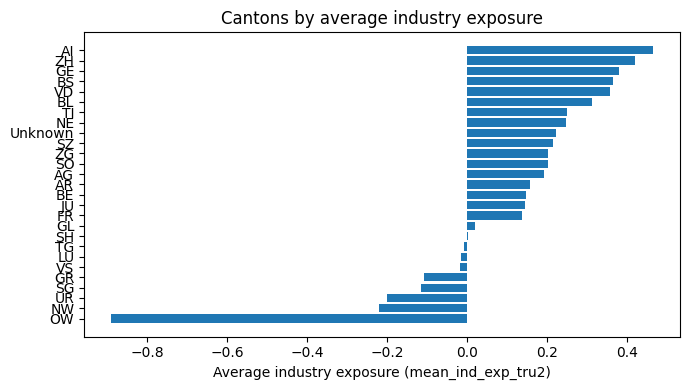

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_canton_top30_avg_industry_exposure.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/2140984879.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics_ind["mean_ind_exp_tru2"] = ind_reg_group.apply(wmean_industry_exp)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/2140984879.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom_ind = ind_reg_group.apply(lambda g: g.loc[g[ind_exp_col].notn

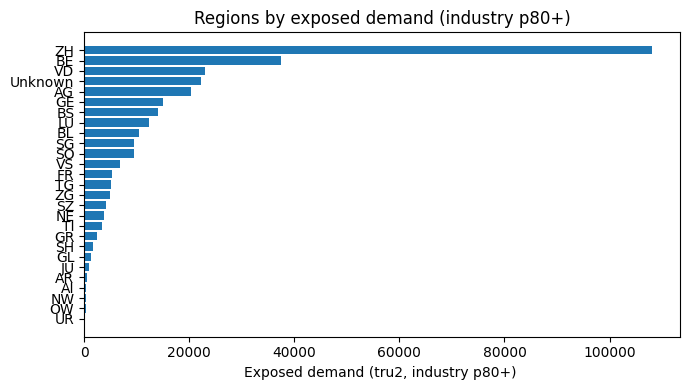

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p80_ind.png


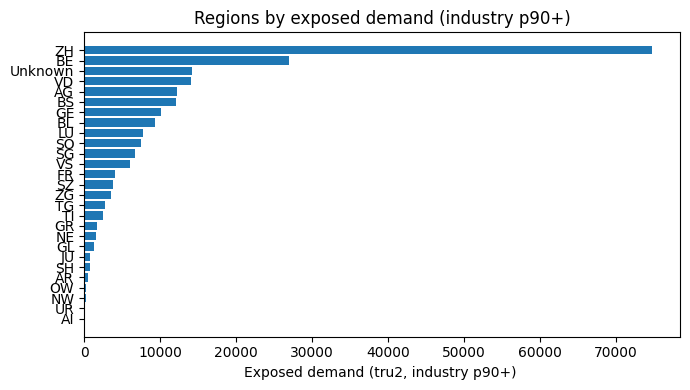

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p90_ind.png


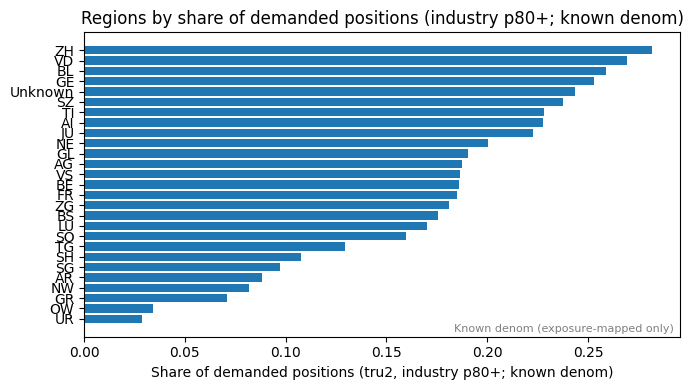

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p80_ind.png


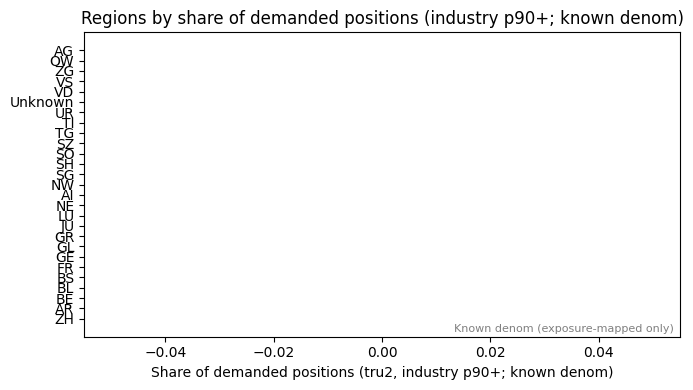

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p90_ind.png


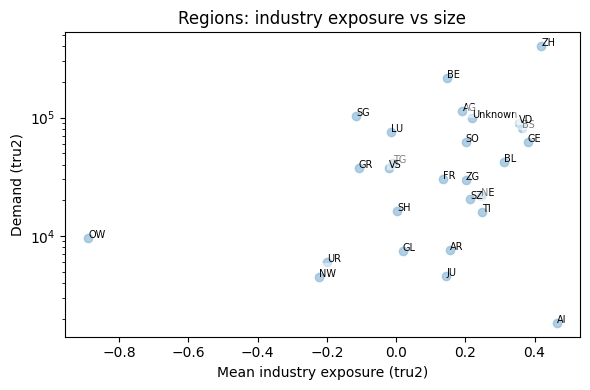

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_scatter_ind.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/2140984879.py:153: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"])


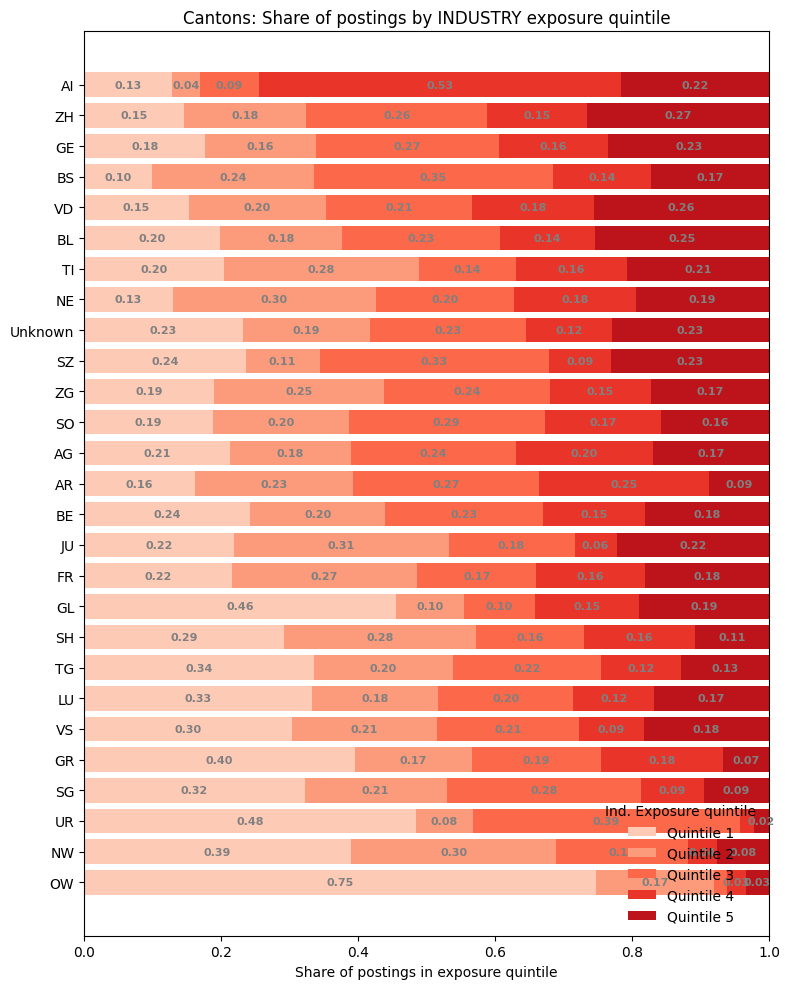

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_quintiles_ind_exp.png


In [179]:
# ==== Plot: average industry exposure per canton ====
# Compute weighted average industry exposure per canton
def wmean_industry_exp(g):
    x = g.loc[g[ind_exp_col].notna(), ind_exp_col]
    w = g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"]
    return np.average(x, weights=w) if len(x) else np.nan

indreg_group = _df.groupby(region_col)
avg_ind_exp_by_kanton = indreg_group.apply(wmean_industry_exp).reset_index(name="mean_ind_exp_tru2")

top_kanton_ind_exp = avg_ind_exp_by_kanton.nlargest(30, "mean_ind_exp_tru2")
plt.figure(figsize=(7,4))
plt.barh(top_kanton_ind_exp[region_col].astype(str), top_kanton_ind_exp["mean_ind_exp_tru2"])
plt.gca().invert_yaxis()
plt.xlabel("Average industry exposure (mean_ind_exp_tru2)")
plt.title("Cantons by average industry exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_canton_top30_avg_industry_exposure.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)
# ==== End plot ====

# Region summary (industry exposure)
ind_reg_group = _df.groupby(region_col)

reg_metrics_ind = ind_reg_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum")
)
reg_metrics_ind["mean_ind_exp_tru2"] = ind_reg_group.apply(wmean_industry_exp)

# exposed demand p80/p90 (industry)
reg_metrics_ind["exposed_demand_p80_ind"] = _df.loc[_df[ind_exp_col] >= ind_p80].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics_ind["exposed_demand_p90_ind"] = _df.loc[_df[ind_exp_col] >= ind_p90].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics_ind = reg_metrics_ind.fillna(0)

# shares
known_denom_ind = ind_reg_group.apply(lambda g: g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics_ind["high_share_total_p80_ind"] = reg_metrics_ind["exposed_demand_p80_ind"] / reg_metrics_ind["demand_total_tru2"]
reg_metrics_ind["high_share_known_p80_ind"] = reg_metrics_ind["exposed_demand_p80_ind"] / known_denom_ind
reg_metrics_ind["coverage_share_ind"] = known_denom_ind / reg_metrics_ind["demand_total_tru2"]

reg_metrics_ind["high_share_total_p90_ind"] = reg_metrics_ind["exposed_demand_p90_ind"] / reg_metrics_ind["demand_total_tru2"]
reg_metrics_ind["high_share_known_p90_ind"] = reg_metrics_ind["exposed_demand_p90_ind"] / known_denom_ind
reg_metrics_ind = reg_metrics_ind.reset_index()
reg_metrics_ind.to_csv(OUT_TABLES / "table_region_summary_industry.csv", index=False)

# Bar charts: exposed demand p80/p90 (industry)
for thresh_label in ["p80","p90"]:
    col = f"exposed_demand_{thresh_label}_ind"
    top_reg = reg_metrics_ind.nlargest(30, col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg[region_col].astype(str), top_reg[col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Exposed demand (tru2, industry {thresh_label}+) ")
    plt.title(f"Regions by exposed demand (industry {thresh_label}+)")
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top15_exposed_{thresh_label}_ind.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Bar charts: share of demanded positions (industry)

for thresh_label in ["p80", "p90"]:
    share_col = f"high_share_known_{thresh_label}_ind"
    plot_data = reg_metrics_ind.copy()
    plot_data[region_col] = plot_data[region_col].fillna("Unknown")
    plot_data[share_col] = pd.to_numeric(plot_data[share_col], errors="coerce").fillna(0)
    top_reg_share = plot_data.nlargest(30, share_col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg_share[region_col].astype(str), top_reg_share[share_col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Share of demanded positions (tru2, industry {thresh_label}+; known denom)")
    plt.title(f"Regions by share of demanded positions (industry {thresh_label}+; known denom)")
    plt.text(0.99, 0.01, 'Known denom (exposure-mapped only)', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=8, color='gray')
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top30_share_{thresh_label}_ind.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Scatter (industry)
plt.figure(figsize=(6,4))
plt.scatter(reg_metrics_ind["mean_ind_exp_tru2"], reg_metrics_ind["demand_total_tru2"], alpha=0.7)
label_set = set()
label_set.update(reg_metrics_ind.nlargest(30, "demand_total_tru2")[region_col].tolist())
label_set.update(reg_metrics_ind.nlargest(30, "mean_ind_exp_tru2")[region_col].tolist())
if "Unknown" in reg_metrics_ind[region_col].values:
    label_set.add("Unknown")
for _, row in reg_metrics_ind[reg_metrics_ind[region_col].isin(label_set)].iterrows():
    plt.text(row["mean_ind_exp_tru2"], row["demand_total_tru2"], str(row[region_col]), fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Regions: industry exposure vs size")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_scatter_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Decomposition: top 5 regions by exposed demand (industry p80)
reg_metrics_ind_sorted = reg_metrics_ind.sort_values("exposed_demand_p80_ind", ascending=False)
top_regions_ind = reg_metrics_ind_sorted.head(5)[region_col].tolist()
rows_occ_ind = []
rows_ind_ind = []
if "occ2_label" not in globals():
    occ2_label = _df["occu_isco2_label"].fillna("Unknown")
for reg in top_regions_ind:
    sub = _df[(_df[region_col] == reg) & (_df[ind_exp_col] >= ind_p80)]
    sub_occ = sub.groupby(occ2_label)["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_occ.items(), start=1):
        rows_occ_ind.append({"region": reg, "rank": rank, "occ2_label": code, "exposed_demand_tru2": val})
    sub_ind = sub.groupby(_df["comp_indu_noga_label"].fillna("Unknown"))["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_ind.items(), start=1):
        rows_ind_ind.append({"region": reg, "rank": rank, "indu_label": code, "exposed_demand_tru2": val})

pd.DataFrame(rows_occ_ind).to_csv(OUT_TABLES / "table_region_top_occ2_contrib_ind.csv", index=False)
pd.DataFrame(rows_ind_ind).to_csv(OUT_TABLES / "table_region_top_ind_contrib_ind.csv", index=False)



# === Plot: horizontal stacked bars for exposure segments per canton (INDUSTRY exposure, includes P90+) ===
# Build exposure segments using global p20/p40/p60/p80/p90 thresholds
ind_p20, ind_p40, ind_p60, ind_p80_seg, ind_p90_seg = np.nanpercentile(_df[ind_exp_col], [20,40,60,80,90])

def _ind_segment(x):
    if pd.isna(x):
        return pd.NA
    if x <= ind_p20:
        return "Q1 (0-20)"
    if x <= ind_p40:
        return "Q2 (20-40)"
    if x <= ind_p60:
        return "Q3 (40-60)"
    if x <= ind_p80_seg:
        return "Q4 (60-80)"
    if x < ind_p90_seg:
        return "Q5 (80-90)"
    return "P90+ (90-100)"

_df["ind_exposure_segment"] = _df[ind_exp_col].apply(_ind_segment)
segments = ["Q1 (0-20)", "Q2 (20-40)", "Q3 (40-60)", "Q4 (60-80)", "Q5 (80-90)", "P90+ (90-100)"]

postings_per_kanton_segment_ind = (
    _df[_df[region_col].notna() & _df["ind_exposure_segment"].notna()]
    .groupby([region_col, "ind_exposure_segment"], observed=True)["srvy_wght_tru2"].sum()
    .unstack(fill_value=0)
)
for seg in segments:
    if seg not in postings_per_kanton_segment_ind.columns:
        postings_per_kanton_segment_ind[seg] = 0

postings_per_kanton_segment_share_ind = postings_per_kanton_segment_ind.div(
    postings_per_kanton_segment_ind.sum(axis=1), axis=0
)
postings_per_kanton_segment_share_ind = postings_per_kanton_segment_share_ind.loc[
    postings_per_kanton_segment_share_ind.sum(axis=1) > 0
]

mean_ind_exposure_by_kanton = (
    _df.groupby(region_col)
    .apply(lambda g: np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"])
           if g[ind_exp_col].notna().any() else 0)
)
plot_order_ind = mean_ind_exposure_by_kanton.loc[postings_per_kanton_segment_share_ind.index].sort_values(ascending=True).index.tolist()
postings_per_kanton_segment_share_ind = postings_per_kanton_segment_share_ind.loc[plot_order_ind]

fig, ax = plt.subplots(figsize=(8, 10))

colormap_ind = plt.get_cmap("Reds")
segment_colors = [colormap_ind(0.15 + 0.12*i) for i in range(len(segments))]

bottom = np.zeros(len(postings_per_kanton_segment_share_ind))
y_labels = postings_per_kanton_segment_share_ind.index.astype(str)

for i, seg in enumerate(segments):
    vals = postings_per_kanton_segment_share_ind[seg].values
    bars = ax.barh(
        y_labels,
        vals,
        left=bottom,
        height=0.8,
        color=segment_colors[i],
        label=seg
    )
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share > 0.02:
            xpos = bottom[j] + share/2
            ypos = bar.get_y() + bar.get_height()/2
            ax.text(
                xpos,
                ypos,
                f"{share:.2f}",
                ha="center",
                va="center",
                color="grey",
                fontsize=8,
                fontweight="bold"
            )
    bottom += vals

ax.set_xlabel("Share of postings in exposure segment")
ax.set_title("Cantons: Share of postings by INDUSTRY exposure segments (includes P90+)")
ax.set_xlim(0, 1)
ax.legend(title="Ind. Exposure segment", loc="lower right", frameon=False)
plt.tight_layout()

fig_path = OUT_VIS / "fig_kanton_stack_segments_ind_exp.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)




# Top 5 industry sections by canton (show all cantons)
section_label_col = _df["industry_section_label"].fillna(_df["industry_section"]).fillna("Unknown")

section_group = (
    _df.assign(_section_label=section_label_col)
       .groupby([region_col, "_section_label"], observed=True)
       .apply(lambda g: pd.Series({
           "demand_tru2": g["srvy_wght_tru2"].sum(),
           "section_exposure_weighted": (
               np.average(g.loc[g["industry_section_exposure_weighted"].notna(), "industry_section_exposure_weighted"],
                          weights=g.loc[g["industry_section_exposure_weighted"].notna(), "srvy_wght_tru2"])
               if g["industry_section_exposure_weighted"].notna().any() else np.nan
           )
       }))
       .reset_index()
)

section_group["rank"] = section_group.groupby(region_col)["demand_tru2"].rank(method="first", ascending=False)
section_top5 = section_group[section_group["rank"] <= 5].copy()
section_top5 = section_top5.sort_values([region_col, "rank"])

section_top5.to_csv(OUT_TABLES / "table_region_top5_industry_section.csv", index=False)
print("Saved", OUT_TABLES / "table_region_top5_industry_section.csv")

# Show all rows (top 5 per canton)
display(section_top5)


## 7) Trends (annual + rolling + binned)

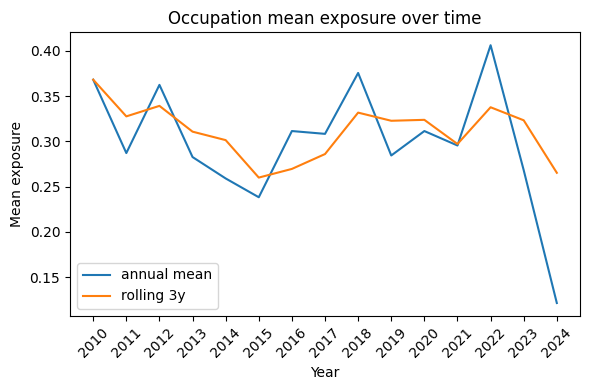

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_occ_allviews.png


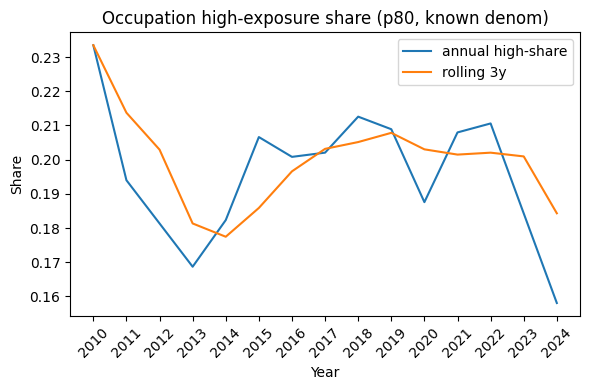

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_occ_allviews_share.png


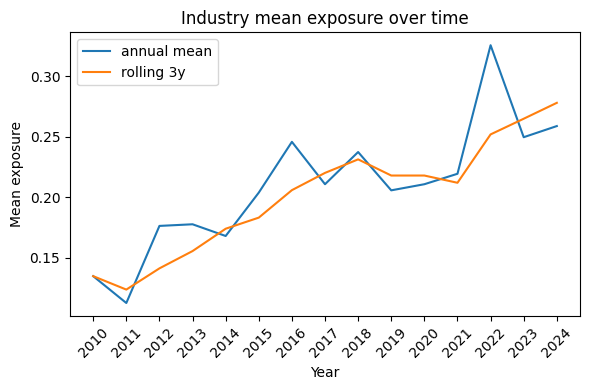

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_ind_allviews.png


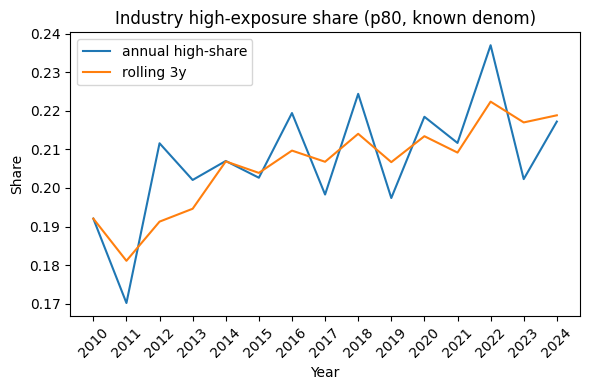

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_ind_allviews_share.png


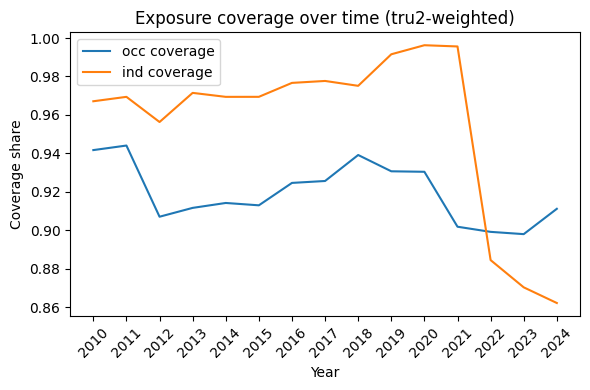

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_coverage_over_time.png


In [75]:
# Annual series
rows = []
for yr, g in _df.groupby('adve_time_year'):
    tot_tru2 = g['srvy_wght_tru2'].sum()
    occ_known = g[occ_exp_col].notna()
    ind_known = g[ind_exp_col].notna()
    row = {
        'year': int(yr),
        'occ_mean_exp': np.average(g.loc[occ_known, occ_exp_col], weights=g.loc[occ_known, 'srvy_wght_tru2']) if occ_known.any() else np.nan,
        'ind_mean_exp': np.average(g.loc[ind_known, ind_exp_col], weights=g.loc[ind_known, 'srvy_wght_tru2']) if ind_known.any() else np.nan,
        'occ_high_share_p80': g.loc[occ_known & (g[occ_exp_col] >= occ_p80), 'srvy_wght_tru2'].sum() / g.loc[occ_known, 'srvy_wght_tru2'].sum() if occ_known.any() else np.nan,
        'ind_high_share_p80': g.loc[ind_known & (g[ind_exp_col] >= ind_p80), 'srvy_wght_tru2'].sum() / g.loc[ind_known, 'srvy_wght_tru2'].sum() if ind_known.any() else np.nan,
        'occ_coverage': g.loc[occ_known, 'srvy_wght_tru2'].sum() / tot_tru2 if tot_tru2 else np.nan,
        'ind_coverage': g.loc[ind_known, 'srvy_wght_tru2'].sum() / tot_tru2 if tot_tru2 else np.nan,
    }
    rows.append(row)
trend_annual = pd.DataFrame(rows).sort_values('year')
trend_annual.to_csv(OUT_TABLES / "table_trends_annual.csv", index=False)

# Rolling 3y
trend_roll = trend_annual.set_index('year').rolling(window=3, min_periods=1).mean().reset_index()
trend_roll.to_csv(OUT_TABLES / "table_trends_rolling3y.csv", index=False)

# Plots: occ
plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['occ_mean_exp'], label='annual mean')
plt.plot(trend_roll['year'], trend_roll['occ_mean_exp'], label='rolling 3y')
plt.title('Occupation mean exposure over time')
plt.xlabel('Year')
plt.ylabel('Mean exposure')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_occ_allviews.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['occ_high_share_p80'], label='annual high-share')
plt.plot(trend_roll['year'], trend_roll['occ_high_share_p80'], label='rolling 3y')
plt.title('Occupation high-exposure share (p80, known denom)')
plt.xlabel('Year')
plt.ylabel('Share')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_occ_allviews_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Plots: ind
plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['ind_mean_exp'], label='annual mean')
plt.plot(trend_roll['year'], trend_roll['ind_mean_exp'], label='rolling 3y')
plt.title('Industry mean exposure over time')
plt.xlabel('Year')
plt.ylabel('Mean exposure')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_ind_allviews.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['ind_high_share_p80'], label='annual high-share')
plt.plot(trend_roll['year'], trend_roll['ind_high_share_p80'], label='rolling 3y')
plt.title('Industry high-exposure share (p80, known denom)')
plt.xlabel('Year')
plt.ylabel('Share')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_trend_ind_allviews_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Coverage over time
plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['occ_coverage'], label='occ coverage')
plt.plot(trend_annual['year'], trend_annual['ind_coverage'], label='ind coverage')
plt.title('Exposure coverage over time (tru2-weighted)')
plt.xlabel('Year')
plt.ylabel('Coverage share')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_coverage_over_time.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)



## 8) Industry vs occupation exposure (correlation + bubble)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


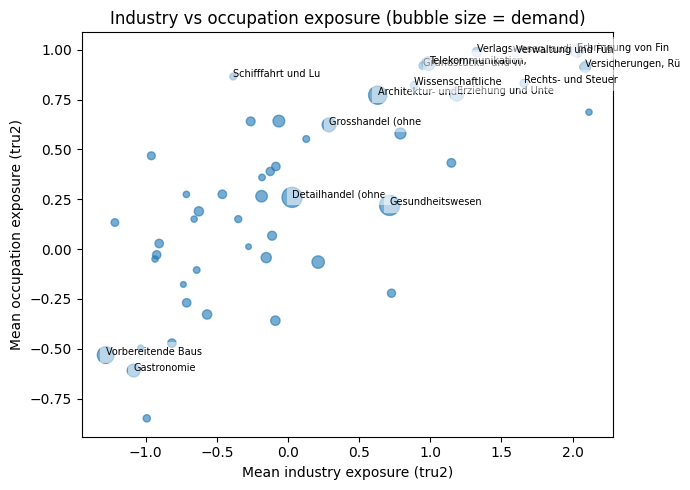

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_vs_occ_exposure_bubble.png
Pearson: 0.7394796086635016
Spearman: 0.7416326530612245
Weighted Pearson: 0.8011408240434118


In [76]:
# Industry-level mix
ind_mix = _df.groupby(_df["comp_indu_noga_label"].fillna("Unknown")).apply(
    lambda g: pd.Series({
        "demand_total_tru2": g["srvy_wght_tru2"].sum(),
        "mean_ind_exp": np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(),"srvy_wght_tru2"]) if g[ind_exp_col].notna().any() else np.nan,
        "mean_occ_exp": np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(),"srvy_wght_tru2"]) if g[occ_exp_col].notna().any() else np.nan,
        "share_high_occ_p80": g.loc[g[occ_exp_col] >= occ_p80, "srvy_wght_tru2"].sum() / g["srvy_wght_tru2"].sum(),
        "coverage": g[occ_exp_col].notna().mean(),
    })
).reset_index().rename(columns={"comp_indu_noga_label":"indu_label"})

ind_mix.to_csv(OUT_TABLES / "table_ind_occ_mix.csv", index=False)

# Bubble scatter
plt.figure(figsize=(7,5))
plt.scatter(ind_mix["mean_ind_exp"], ind_mix["mean_occ_exp"], s=(ind_mix["demand_total_tru2"] / ind_mix["demand_total_tru2"].max())*200+10, alpha=0.6)
label_set = set()
label_set.update(ind_mix.nlargest(10, "demand_total_tru2")["indu_label"].tolist())
label_set.update(ind_mix.nlargest(10, "mean_occ_exp")["indu_label"].tolist())
for _, row in ind_mix[ind_mix["indu_label"].isin(label_set)].iterrows():
    plt.text(row["mean_ind_exp"], row["mean_occ_exp"], str(row["indu_label"])[:18], fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Mean occupation exposure (tru2)")
plt.title("Industry vs occupation exposure (bubble size = demand)")
plt.tight_layout()
fig_path = OUT_VIS / "fig_ind_vs_occ_exposure_bubble.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Correlations (unweighted + weighted)
valid = ind_mix.dropna(subset=["mean_ind_exp", "mean_occ_exp"])
pearson = valid[["mean_ind_exp","mean_occ_exp"]].corr().iloc[0,1]
# Spearman
spearman = valid[["mean_ind_exp","mean_occ_exp"]].corr(method="spearman").iloc[0,1]

# Weighted Pearson
w = valid["demand_total_tru2"].to_numpy()
xi = valid["mean_ind_exp"].to_numpy()
yi = valid["mean_occ_exp"].to_numpy()
wmx = np.average(xi, weights=w)
wmy = np.average(yi, weights=w)
wcov = np.average((xi-wmx)*(yi-wmy), weights=w)
wsx = np.sqrt(np.average((xi-wmx)**2, weights=w))
wsy = np.sqrt(np.average((yi-wmy)**2, weights=w))
weighted_pearson = wcov / (wsx*wsy) if wsx>0 and wsy>0 else np.nan

print("Pearson:", pearson)
print("Spearman:", spearman)
print("Weighted Pearson:", weighted_pearson)


## 9) Avg demand per posting by exposure decile

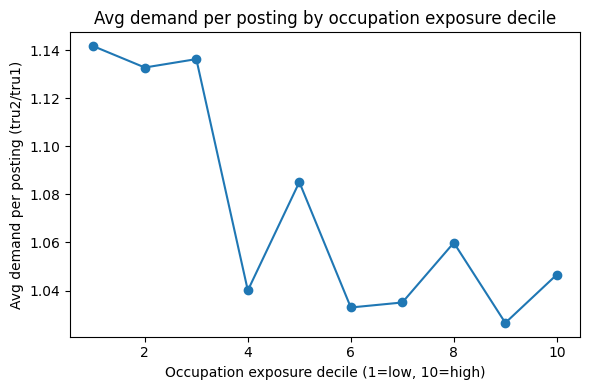

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_avg_demand_per_posting_by_decile.png


In [77]:
# Deciles on occupation exposure (unweighted)
occ_nonmiss = _df[_df[occ_exp_col].notna()].copy()
occ_nonmiss["occ_decile"] = pd.qcut(occ_nonmiss[occ_exp_col], 10, labels=False) + 1

occ_dec = occ_nonmiss.groupby("occ_decile").agg(
    demand_tru2=("srvy_wght_tru2","sum"),
    postings_tru1=("srvy_wght_tru1","sum")
).reset_index()
occ_dec["avg_demand_per_posting"] = occ_dec["demand_tru2"] / occ_dec["postings_tru1"]
occ_dec.to_csv(OUT_TABLES / "table_occ_deciles.csv", index=False)

plt.figure(figsize=(6,4))
plt.plot(occ_dec["occ_decile"], occ_dec["avg_demand_per_posting"], marker='o')
plt.xlabel("Occupation exposure decile (1=low, 10=high)")
plt.ylabel("Avg demand per posting (tru2/tru1)")
plt.title("Avg demand per posting by occupation exposure decile")
plt.tight_layout()
fig_path = OUT_VIS / "fig_avg_demand_per_posting_by_decile.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


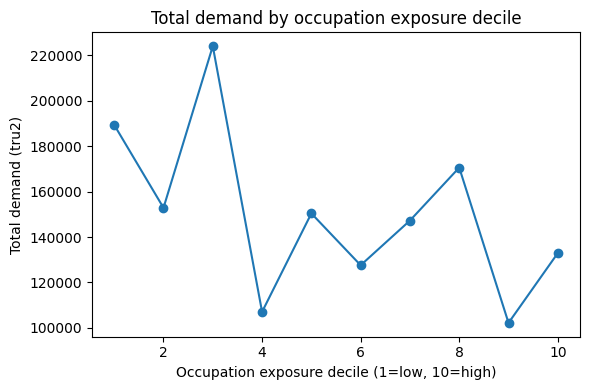

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_total_demand_by_decile.png


In [78]:
# Deciles on occupation exposure (unweighted) - tru2 only

# Use the same DataFrame as the cell above for consistency
# Assume 'occ_nonmiss' is already created from the previous cell

occ_dec2 = occ_nonmiss.groupby("occ_decile").agg(
    demand_tru2=("srvy_wght_tru2", "sum"),
).reset_index()

plt.figure(figsize=(6,4))
plt.plot(occ_dec2["occ_decile"], occ_dec2["demand_tru2"], marker='o')
plt.xlabel("Occupation exposure decile (1=low, 10=high)")
plt.ylabel("Total demand (tru2)")
plt.title("Total demand by occupation exposure decile")
plt.tight_layout()
fig_path2 = OUT_VIS / "fig_total_demand_by_decile.png"
plt.savefig(fig_path2, dpi=150)
plt.show()
print("Saved", fig_path2)





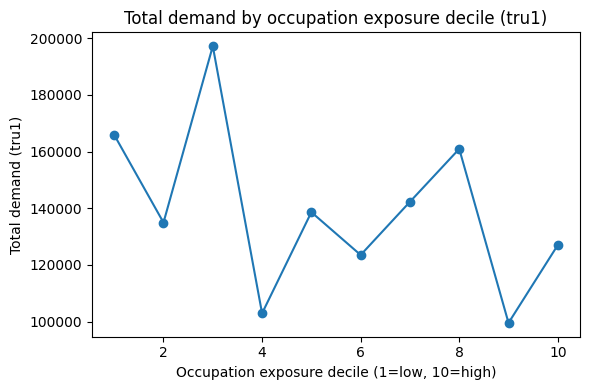

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_total_demand_by_decile_tru1.png


In [79]:
# Deciles on occupation exposure (unweighted) - tru1 only

# Use the same DataFrame as the cell above for consistency
# Assume 'occ_nonmiss' is already created from the previous cell

occ_dec3 = occ_nonmiss.groupby("occ_decile").agg(
    demand_tru1=("srvy_wght_tru1", "sum"),
).reset_index()

plt.figure(figsize=(6,4))
plt.plot(occ_dec3["occ_decile"], occ_dec3["demand_tru1"], marker='o')
plt.xlabel("Occupation exposure decile (1=low, 10=high)")
plt.ylabel("Total demand (tru1)")
plt.title("Total demand by occupation exposure decile (tru1)")
plt.tight_layout()
fig_path3 = OUT_VIS / "fig_total_demand_by_decile_tru1.png"
plt.savefig(fig_path3, dpi=150)
plt.show()
print("Saved", fig_path3)


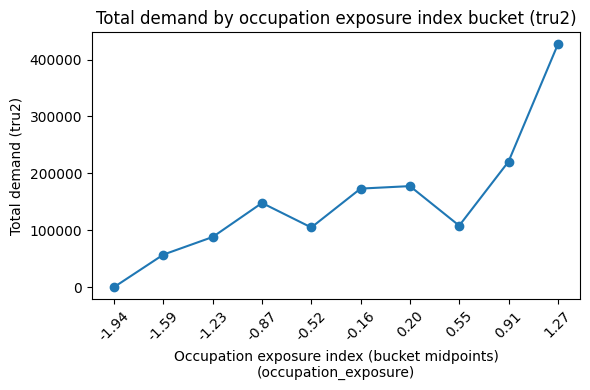

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_total_demand_by_exposure_bucket_tru2_scale.png


In [80]:
# Plot total demand (tru2) vs. true occupation exposure index using "occupation_exposure" and bucket along its real scale
import numpy as np

exposure_col = "occupation_exposure"
if exposure_col not in occ_nonmiss.columns:
    print(
        f"Could not find occupation exposure index column in occ_nonmiss.\n"
        f"Expected column: '{exposure_col}'\n"
        f"Available columns: {list(occ_nonmiss.columns)}"
    )
else:
    num_buckets = 10
    min_exp = occ_nonmiss[exposure_col].min()
    max_exp = occ_nonmiss[exposure_col].max()
    bucket_edges = np.linspace(min_exp, max_exp, num_buckets + 1)

    # Bin into intervals (show bucket as NaN if exposure is missing)
    occ_nonmiss["occ_exp_bucket"] = pd.cut(
        occ_nonmiss[exposure_col],
        bins=bucket_edges,
        labels=False,
        include_lowest=True
    )

    # Compute midpoint of each bucket for x-axis
    bucket_mids = (bucket_edges[:-1] + bucket_edges[1:]) / 2

    # Aggregate tru2 demand per bucket
    bucket_demand = (
        occ_nonmiss.groupby("occ_exp_bucket")
        .agg(demand_tru2=("srvy_wght_tru2", "sum"))
        .reset_index()
    )

    # Attach exposure-value midpoints for x-axis labeling
    bucket_demand["exposure_mid"] = bucket_demand["occ_exp_bucket"].map(
        lambda i: bucket_mids[int(i)] if not np.isnan(i) and int(i) < len(bucket_mids) else np.nan
    )

    plt.figure(figsize=(6,4))
    plt.plot(bucket_demand["exposure_mid"], bucket_demand["demand_tru2"], marker='o')
    plt.xlabel(f"Occupation exposure index (bucket midpoints)\n({exposure_col})")
    plt.ylabel("Total demand (tru2)")
    plt.title("Total demand by occupation exposure index bucket (tru2)")
    # Custom x-ticks at midpoints with proper precision
    plt.xticks(bucket_mids, [f"{m:.2f}" for m in bucket_mids], rotation=45)
    plt.tight_layout()
    fig_path4 = OUT_VIS / "fig_total_demand_by_exposure_bucket_tru2_scale.png"
    plt.savefig(fig_path4, dpi=150)
    plt.show()
    print("Saved", fig_path4)









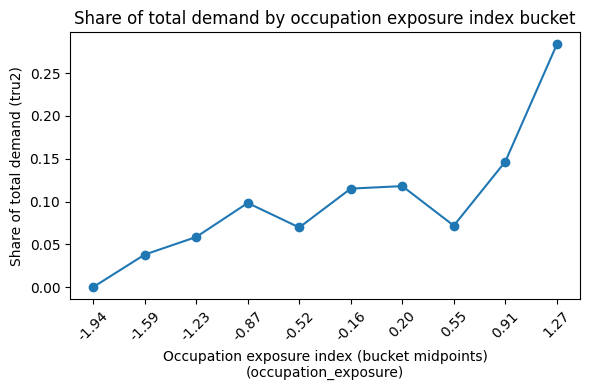

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_share_total_demand_by_exposure_bucket_tru2.png


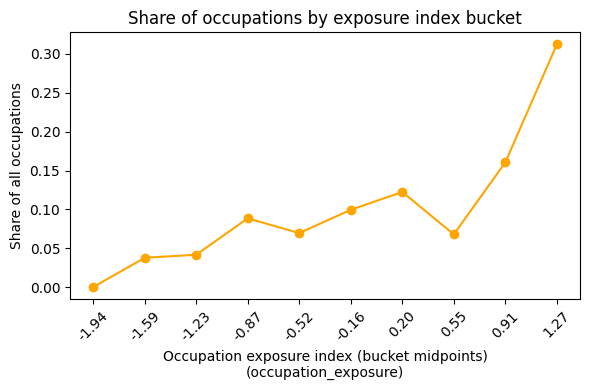

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_share_occupations_by_exposure_bucket.png


In [81]:
# 1. Plot: y = share of total tru2 per exposure bucket (use same binning as before)
bucket_total_tru2 = bucket_demand["demand_tru2"].sum()
bucket_demand["share_of_tru2"] = bucket_demand["demand_tru2"] / bucket_total_tru2

plt.figure(figsize=(6,4))
plt.plot(bucket_demand["exposure_mid"], bucket_demand["share_of_tru2"], marker='o')
plt.xlabel(f"Occupation exposure index (bucket midpoints)\n({exposure_col})")
plt.ylabel("Share of total demand (tru2)")
plt.title("Share of total demand by occupation exposure index bucket")
plt.xticks(bucket_mids, [f"{m:.2f}" for m in bucket_mids], rotation=45)
plt.tight_layout()
fig_path4b = OUT_VIS / "fig_share_total_demand_by_exposure_bucket_tru2.png"
plt.savefig(fig_path4b, dpi=150)
plt.show()
print("Saved", fig_path4b)

# 2. Do the same plot, but with raw count of occupations in each bucket
bucket_demand_count = (
    occ_nonmiss.groupby("occ_exp_bucket")
    .size()
    .reset_index(name="count_occupations")
)
bucket_demand_count["exposure_mid"] = bucket_demand_count["occ_exp_bucket"].map(
    lambda i: bucket_mids[int(i)] if not np.isnan(i) and int(i) < len(bucket_mids) else np.nan
)
total_occupations = bucket_demand_count["count_occupations"].sum()
bucket_demand_count["share_of_occupations"] = bucket_demand_count["count_occupations"] / total_occupations

plt.figure(figsize=(6,4))
plt.plot(bucket_demand_count["exposure_mid"], bucket_demand_count["share_of_occupations"], marker='o', color="orange")
plt.xlabel(f"Occupation exposure index (bucket midpoints)\n({exposure_col})")
plt.ylabel("Share of all occupations")
plt.title("Share of occupations by exposure index bucket")
plt.xticks(bucket_mids, [f"{m:.2f}" for m in bucket_mids], rotation=45)
plt.tight_layout()
fig_path4c = OUT_VIS / "fig_share_occupations_by_exposure_bucket.png"
plt.savefig(fig_path4c, dpi=150)
plt.show()
print("Saved", fig_path4c)



/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_75159/1380710981.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_75159/1380710981.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


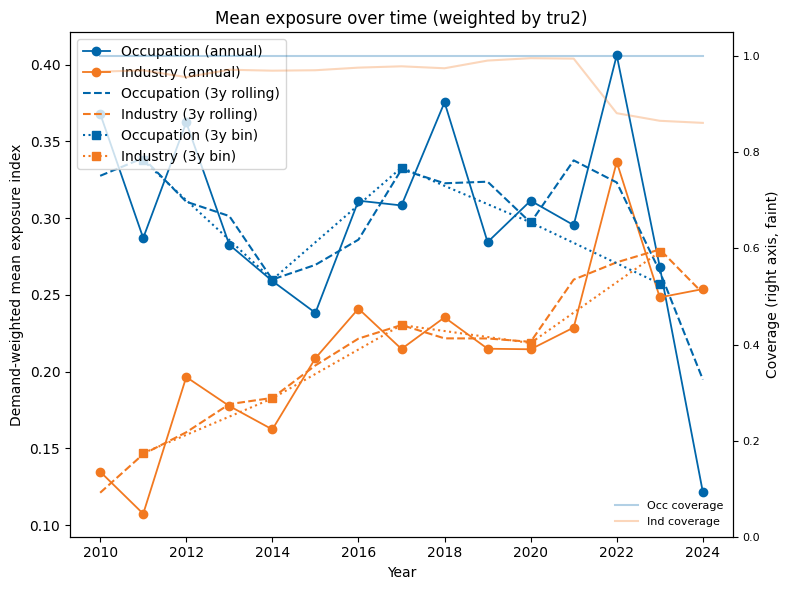

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_mean_exposure_over_time_tru2.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_75159/1380710981.py:151: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="lower right", fontsize=8, frameon=False)


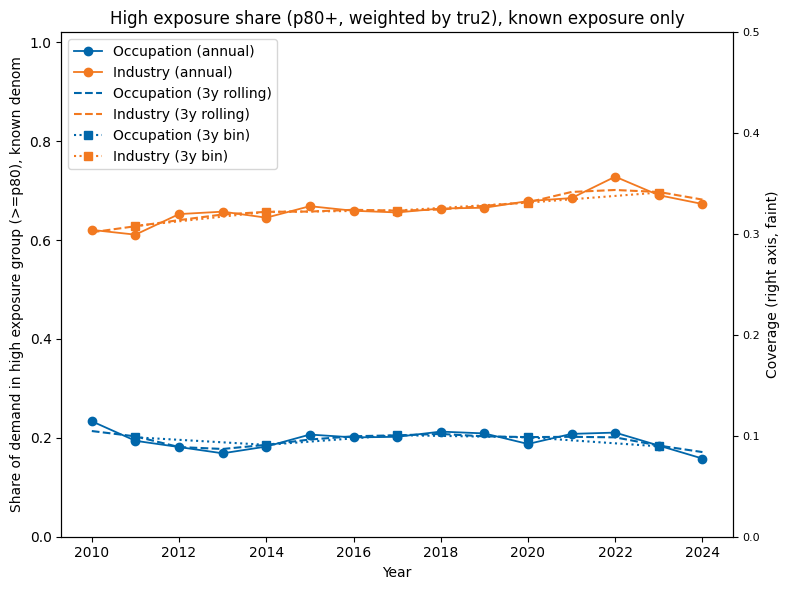

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_high_exposure_share_over_time_tru2.png


In [82]:
import pandas as pd

# Define parameters
YEARS = range(2010, 2025)
OCC_EXP_COL = exposure_col  # e.g., 'occupation_exposure'
IND_EXP_COL = "industry_exposure_weighted"
WEIGHT_COL = "srvy_wght_tru2"
YEAR_COL = "adve_time_year"

# ## ---- PATCH: HARDCODE P80 THRESHOLDS HERE ----
# These values were printed in prior context (cell output 3):
# occ_p80: 1.2383682999999999
# ind_p80: -0.11150409999999998
occ_p80 = 1.2383682999999999
ind_p80 = -0.11150409999999998

# Helper: for 3-year bins
def assign_bin(year, binwidth=3):
    return year - (year - YEARS[0]) % binwidth

# 1. Prepare reduced dataframe (in case not already filtered)
df_ = occ_nonmiss.copy()
df_ = df_[(df_[YEAR_COL] >= min(YEARS)) & (df_[YEAR_COL] <= max(YEARS))]

# 2. Metrics computations ----------

def demand_wmean(x, val, wgt):
    weights = x[wgt][x[val].notna()]
    values = x[val][x[val].notna()]
    return (weights * values).sum() / weights.sum() if not weights.empty else np.nan

def demand_high_share(x, val, wgt, pthresh):
    mask = x[val].notna()
    if mask.sum() == 0:
        return np.nan
    numer = x[wgt][mask & (x[val] >= pthresh)].sum()
    denom = x[wgt][mask].sum()
    return numer / denom if denom > 0 else np.nan

def demand_coverage(x, val, wgt):
    numer = x[wgt][x[val].notna()].sum()
    denom = x[wgt].sum()
    return numer / denom if denom > 0 else np.nan

# 2.1 Annual metrics

annual = (
    df_
    .groupby(YEAR_COL)
    .apply(lambda x: pd.Series({
        "wmean_occ_exp": demand_wmean(x, OCC_EXP_COL, WEIGHT_COL),
        "wmean_ind_exp": demand_wmean(x, IND_EXP_COL, WEIGHT_COL),
        "high_share_occ": demand_high_share(x, OCC_EXP_COL, WEIGHT_COL, occ_p80),
        "high_share_ind": demand_high_share(x, IND_EXP_COL, WEIGHT_COL, ind_p80),
        "coverage_occ": demand_coverage(x, OCC_EXP_COL, WEIGHT_COL),
        "coverage_ind": demand_coverage(x, IND_EXP_COL, WEIGHT_COL),
    }))
    .reset_index()
)

# 2.2 3-year rolling mean (centered)
annual_rolling = annual.set_index(YEAR_COL).rolling(window=3, center=True, min_periods=1).mean().reset_index()
annual_rolling["bin3y"] = annual_rolling[YEAR_COL]  # Convenient for plotting

# 2.3 3-year bins (use bin midpoint)
df_["bin3y"] = df_[YEAR_COL].apply(assign_bin)
bin_groups = (
    df_
    .groupby("bin3y")
    .apply(lambda x: pd.Series({
        "wmean_occ_exp": demand_wmean(x, OCC_EXP_COL, WEIGHT_COL),
        "wmean_ind_exp": demand_wmean(x, IND_EXP_COL, WEIGHT_COL),
        "high_share_occ": demand_high_share(x, OCC_EXP_COL, WEIGHT_COL, occ_p80),
        "high_share_ind": demand_high_share(x, IND_EXP_COL, WEIGHT_COL, ind_p80),
        "coverage_occ": demand_coverage(x, OCC_EXP_COL, WEIGHT_COL),
        "coverage_ind": demand_coverage(x, IND_EXP_COL, WEIGHT_COL),
    }))
    .reset_index()
)
bin_groups["bin3y_mid"] = bin_groups["bin3y"] + 1  # For x-axis label (midpoint of 3 years)

# 3. PLOTS ================

import matplotlib.pyplot as plt

colors = {"occ": "#0066AA", "ind": "#F27920"}

### A) Mean exposure over time (tru2) - two lines

plt.figure(figsize=(8,6))
# Annual
plt.plot(annual[YEAR_COL], annual["wmean_occ_exp"], label="Occupation (annual)", color=colors["occ"], marker="o", lw=1.3)
plt.plot(annual[YEAR_COL], annual["wmean_ind_exp"], label="Industry (annual)", color=colors["ind"], marker="o", lw=1.3)

# Rolling
plt.plot(annual_rolling[YEAR_COL], annual_rolling["wmean_occ_exp"], label="Occupation (3y rolling)", color=colors["occ"], linestyle="--")
plt.plot(annual_rolling[YEAR_COL], annual_rolling["wmean_ind_exp"], label="Industry (3y rolling)", color=colors["ind"], linestyle="--")

# Binned
plt.plot(bin_groups["bin3y_mid"], bin_groups["wmean_occ_exp"], label="Occupation (3y bin)", color=colors["occ"], marker="s", linestyle=":")
plt.plot(bin_groups["bin3y_mid"], bin_groups["wmean_ind_exp"], label="Industry (3y bin)", color=colors["ind"], marker="s", linestyle=":")

plt.xlabel("Year")
plt.ylabel("Demand-weighted mean exposure index")
plt.title("Mean exposure over time (weighted by tru2)")
plt.xticks(list(YEARS)[::2])
plt.legend(loc="upper left")

# Plot coverage as small lines on right axis
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(annual[YEAR_COL], annual["coverage_occ"], color=colors["occ"], ls="-", alpha=0.3, label="Occ coverage")
ax2.plot(annual[YEAR_COL], annual["coverage_ind"], color=colors["ind"], ls="-", alpha=0.3, label="Ind coverage")
ax2.set_ylabel("Coverage (right axis, faint)")
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', labelsize=8)
ax2.legend(loc="lower right", fontsize=8, frameon=False)
plt.tight_layout()
fig_meanexp_path = OUT_VIS / "fig_mean_exposure_over_time_tru2.png"
plt.savefig(fig_meanexp_path, dpi=150)
plt.show()
print("Saved", fig_meanexp_path)

### B) High-exposure share (p80, known denom, tru2) - two lines

plt.figure(figsize=(8,6))
plt.plot(annual[YEAR_COL], annual["high_share_occ"], label="Occupation (annual)", color=colors["occ"], marker="o", lw=1.3)
plt.plot(annual[YEAR_COL], annual["high_share_ind"], label="Industry (annual)", color=colors["ind"], marker="o", lw=1.3)

plt.plot(annual_rolling[YEAR_COL], annual_rolling["high_share_occ"], label="Occupation (3y rolling)", color=colors["occ"], linestyle="--")
plt.plot(annual_rolling[YEAR_COL], annual_rolling["high_share_ind"], label="Industry (3y rolling)", color=colors["ind"], linestyle="--")

plt.plot(bin_groups["bin3y_mid"], bin_groups["high_share_occ"], label="Occupation (3y bin)", color=colors["occ"], marker="s", linestyle=":")
plt.plot(bin_groups["bin3y_mid"], bin_groups["high_share_ind"], label="Industry (3y bin)", color=colors["ind"], marker="s", linestyle=":")

plt.xlabel("Year")
plt.ylabel("Share of demand in high exposure group (>=p80), known denom")
plt.title("High exposure share (p80+, weighted by tru2), known exposure only")
plt.ylim(0, 1.02)
plt.xticks(list(YEARS)[::2])
plt.legend(loc="upper left")

# Plot coverage
ax1 = plt.gca()
ax2 = ax1.twinx()
#ax2.plot(annual[YEAR_COL], annual["coverage_occ"], color=colors["occ"], ls="-", alpha=0.3, label="Occ coverage")
#ax2.plot(annual[YEAR_COL], annual["coverage_ind"], color=colors["ind"], ls="-", alpha=0.3, label="Ind coverage")
ax2.set_ylabel("Coverage (right axis, faint)")
ax2.set_ylim(0, 0.5)
ax2.tick_params(axis='y', labelsize=8)
ax2.legend(loc="lower right", fontsize=8, frameon=False)
plt.tight_layout()
fig_highshare_path = OUT_VIS / "fig_high_exposure_share_over_time_tru2.png"
plt.savefig(fig_highshare_path, dpi=150)
plt.show()
print("Saved", fig_highshare_path)




Columns available in 'annual': ['adve_time_year', 'wmean_occ_exp', 'wmean_ind_exp', 'high_share_occ', 'high_share_ind', 'coverage_occ', 'coverage_ind']


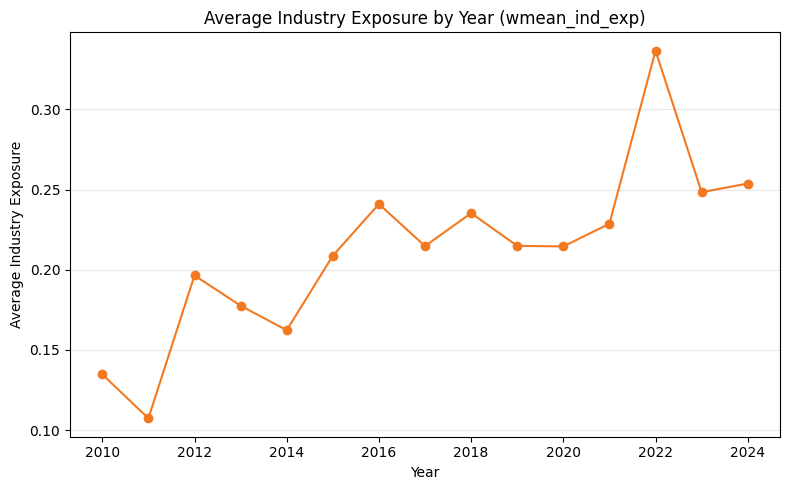

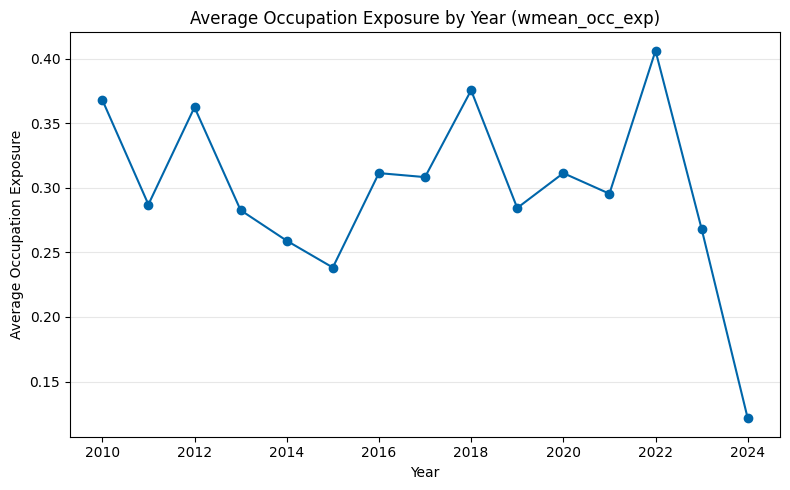

In [83]:
# It appears the columns 'mean_ind_exp_tru2', 'mean_occ_exp_tru2', and 'ind_exp_tru2' do not exist in annual.
# The mean exposure series may instead already be calculated in annual as 'mean_ind_exp' and 'mean_occ_exp' or similar.
# Let's inspect annual.columns and plot any mean exposure columns per year.
# If such columns do not exist, we will skip plotting and display an informative message.

print("Columns available in 'annual':", list(annual.columns))

# Try to infer column names for mean exposures
mean_ind_col = None
mean_occ_col = None
for c in annual.columns:
    cl = c.lower()
    if "mean" in cl and ("ind" in cl or "industry" in cl) and ("tru2" in cl or True):
        mean_ind_col = c
    if "mean" in cl and ("occ" in cl or "occupation" in cl) and ("tru2" in cl or True):
        mean_occ_col = c

if mean_ind_col is not None:
    plt.figure(figsize=(8, 5))
    plt.plot(annual[YEAR_COL], annual[mean_ind_col], color=colors["ind"], marker="o", lw=1.5)
    plt.xlabel("Year")
    plt.ylabel("Average Industry Exposure")
    plt.title(f"Average Industry Exposure by Year ({mean_ind_col})")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No column found for mean industry exposure in 'annual'.")

if mean_occ_col is not None:
    plt.figure(figsize=(8, 5))
    plt.plot(annual[YEAR_COL], annual[mean_occ_col], color=colors["occ"], marker="o", lw=1.5)
    plt.xlabel("Year")
    plt.ylabel("Average Occupation Exposure")
    plt.title(f"Average Occupation Exposure by Year ({mean_occ_col})")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No column found for mean occupation exposure in 'annual'.")




